# CMPE255 Project

## US Traffic Accidents Dataset

We are interested in analyzing details of a traffic accident and its correlation with the **severity of the accident** and the **length of road affected by an accident**.

In [2]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import ElasticNet, LinearRegression, TweedieRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
# import xgboost as xgb
%matplotlib inline

## Data exploration

In [3]:
# Import dataset
features = pd.read_csv('data/US_Accidents_Dec20.csv')
features.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [4]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4232541 entries, 0 to 4232540
Data columns (total 49 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   TMC                    float64
 3   Severity               int64  
 4   Start_Time             object 
 5   End_Time               object 
 6   Start_Lat              float64
 7   Start_Lng              float64
 8   End_Lat                float64
 9   End_Lng                float64
 10  Distance(mi)           float64
 11  Description            object 
 12  Number                 float64
 13  Street                 object 
 14  Side                   object 
 15  City                   object 
 16  County                 object 
 17  State                  object 
 18  Zipcode                object 
 19  Country                object 
 20  Timezone               object 
 21  Airport_Code           object 
 22  Weather_Timestamp 

In [5]:
features.nunique()

ID                       4232541
Source                         3
TMC                           21
Severity                       4
Start_Time               3657563
End_Time                 3775982
Start_Lat                1371599
Start_Lng                1371288
End_Lat                   587824
End_Lng                   599916
Distance(mi)               14619
Description              2166721
Number                     43868
Street                    210786
Side                           3
City                       12250
County                      1752
State                         49
Zipcode                   494306
Country                        1
Timezone                       4
Airport_Code                2022
Weather_Timestamp         616787
Temperature(F)               840
Wind_Chill(F)                984
Humidity(%)                  100
Pressure(in)                1041
Visibility(mi)                87
Wind_Direction                24
Wind_Speed(mph)              162
Precipitat

In [6]:
# Check NAs
features.isna().sum()

ID                             0
Source                         0
TMC                      1516064
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  2716477
End_Lng                  2716477
Distance(mi)                   0
Description                    2
Number                   2687949
Street                         0
Side                           0
City                         137
County                         0
State                          0
Zipcode                     1292
Country                        0
Timezone                    4615
Airport_Code                8973
Weather_Timestamp          62644
Temperature(F)             89900
Wind_Chill(F)            1896001
Humidity(%)                95467
Pressure(in)               76384
Visibility(mi)             98668
Wind_Direction             83611
Wind_Speed(mph)           479326
Precipitat

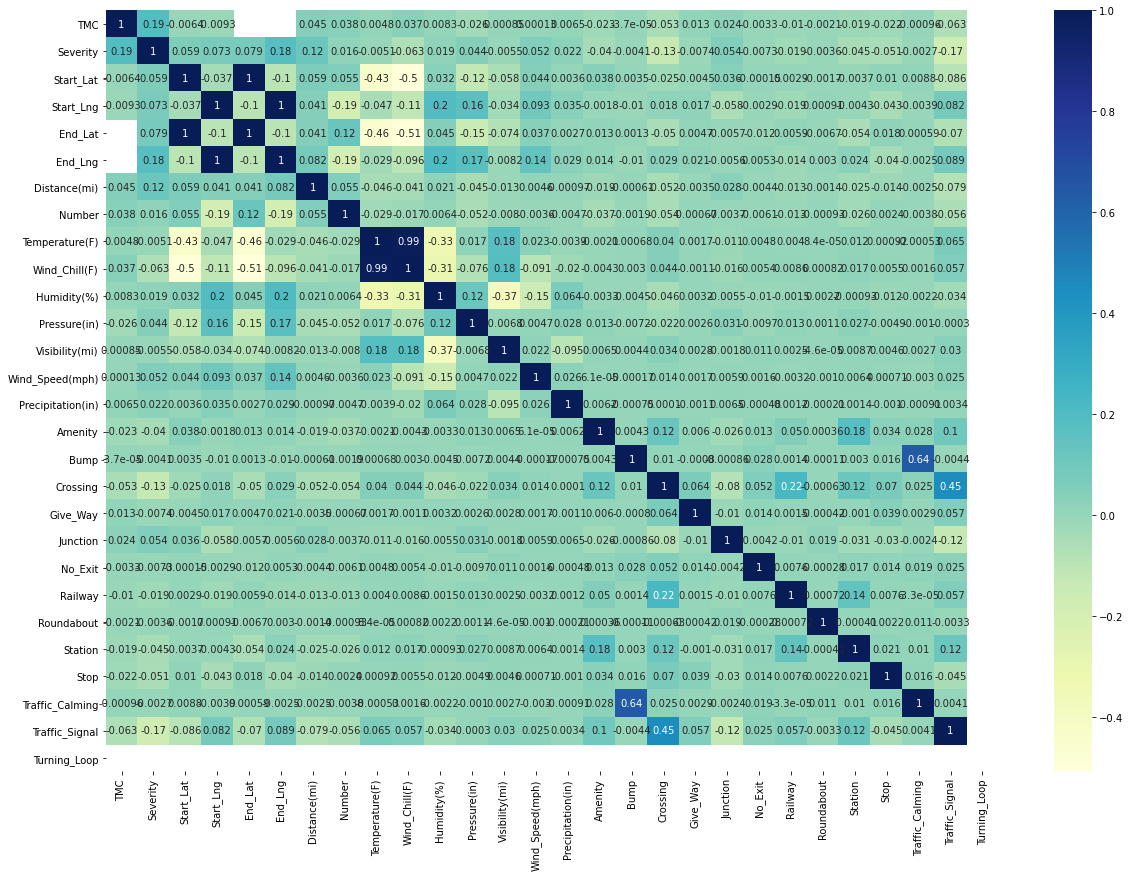

In [7]:
# Heatmap of correlation
plt.figure(figsize=(20, 14))
corr = features.corr()
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.show()

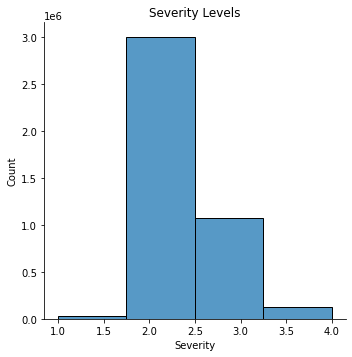

In [8]:
# Check distribution of severity
sns.displot(features, x='Severity', bins=4)
plt.title('Severity Levels')
plt.show()

## Data preprocessing

There are many features that immediately do not tell us much about an accident, such as the **Accident ID** and **Source** from which the data was retrieved from. There are some features that are also redundant or have only 1 value across the entire dataset, such as **Country** and **Turning_Loop**. There are also features with too many missing values, such as **Wind_Chill(F)**. As such, we will be dropping these features. 

In [9]:
# Drop features
to_drop = ['ID', 
           'Source',
           'End_Lat', 
           'End_Lng', 
           'Description', 
           'Number', 
#            'Street',
           'City',
           'County',
           'Zipcode', 
           'Country', 
           'Timezone', 
           'Airport_Code', 
           'Weather_Timestamp', 
           'Wind_Chill(F)', 
           'Precipitation(in)', 
           'Amenity', 
           'Turning_Loop', 
           'Civil_Twilight', 
           'Nautical_Twilight', 
           'Astronomical_Twilight']

features = features.drop(columns=to_drop)

In [10]:
# Extract time data
features['Start_Time'] = pd.to_datetime(features['Start_Time'], errors='coerce')
features['End_Time'] = pd.to_datetime(features['End_Time'], errors='coerce')

features['Year'] = features['Start_Time'].dt.year
features['Month'] = features['Start_Time'].dt.strftime('%b')
features['Day'] = features['Start_Time'].dt.day
features['Hour'] = features['Start_Time'].dt.hour
features['Weekday'] = features['Start_Time'].dt.strftime('%a')

features['Time_Duration(min)'] = round((features['End_Time'] - features['Start_Time']) / np.timedelta64(1,'m'))

In [11]:
# Drop start and end time
features.drop(columns=['Start_Time', 'End_Time'], inplace=True)

# Check for any negative time durations 
duration_check = features['Time_Duration(min)'] <= 0
duration_check.unique()

array([False])

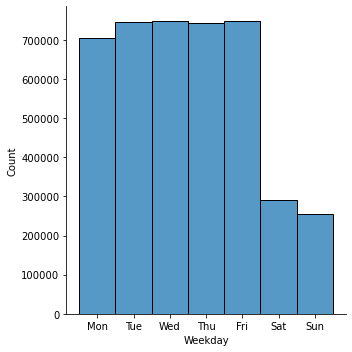

In [12]:
# Plots based on time
sns.displot(features, x='Weekday')

In [13]:
# Drop outliers
features = features[(features['Distance(mi)'] > features['Distance(mi)'].quantile(0.003)) & (features['Distance(mi)'] < features['Distance(mi)'].quantile(0.997))]

In [14]:
# Fill NAs 
features['TMC'].fillna(features['TMC'].mode()[0], inplace=True)
features['Temperature(F)'].fillna(features['Temperature(F)'].mean(), inplace=True)
features['Humidity(%)'].fillna(features['Humidity(%)'].median(), inplace=True)
features['Pressure(in)'].fillna(features['Pressure(in)'].mean(), inplace=True)
features['Visibility(mi)'].fillna(features['Visibility(mi)'].mode()[0], inplace=True)
features['Wind_Speed(mph)'].fillna(features['Wind_Speed(mph)'].mean(), inplace=True)
features['Wind_Direction'].fillna(features['Wind_Direction'].mode()[0], inplace=True)
features['Weather_Condition'].fillna(features['Weather_Condition'].mode()[0], inplace=True)
features['Sunrise_Sunset'].fillna(features['Sunrise_Sunset'].mode()[0], inplace=True)

In [15]:
# Standardize wind direction
features['Wind_Direction'].loc[features['Wind_Direction'] == 'Calm'] = 'CALM'
features['Wind_Direction'].loc[features['Wind_Direction'] == 'South'] = 'S'
features['Wind_Direction'].loc[features['Wind_Direction'] == 'North'] = 'N'
features['Wind_Direction'].loc[features['Wind_Direction'] == 'East'] = 'E'
features['Wind_Direction'].loc[features['Wind_Direction'] == 'West'] = 'W'
features['Wind_Direction'].loc[features['Wind_Direction'] == 'Variable'] = 'VAR'

/home/benny/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [16]:
features.isna().sum()

TMC                   0
Severity              0
Start_Lat             0
Start_Lng             0
Distance(mi)          0
Street                0
Side                  0
State                 0
Temperature(F)        0
Humidity(%)           0
Pressure(in)          0
Visibility(mi)        0
Wind_Direction        0
Wind_Speed(mph)       0
Weather_Condition     0
Bump                  0
Crossing              0
Give_Way              0
Junction              0
No_Exit               0
Railway               0
Roundabout            0
Station               0
Stop                  0
Traffic_Calming       0
Traffic_Signal        0
Sunrise_Sunset        0
Year                  0
Month                 0
Day                   0
Hour                  0
Weekday               0
Time_Duration(min)    0
dtype: int64

In [17]:
# Encode categorical data
enc = LabelEncoder()
features['Street'] = enc.fit_transform(features['Street'])
features['Side'] = enc.fit_transform(features['Side'])
features['State'] = enc.fit_transform(features['State'])
features['Wind_Direction'] = enc.fit_transform(features['Wind_Direction'])
features['Weather_Condition'] = enc.fit_transform(features['Weather_Condition'])
features['Bump'] = enc.fit_transform(features['Bump'])
features['Crossing'] = enc.fit_transform(features['Crossing'])
features['Give_Way'] = enc.fit_transform(features['Give_Way'])
features['Junction'] = enc.fit_transform(features['Junction'])
features['No_Exit'] = enc.fit_transform(features['No_Exit'])
features['Railway'] = enc.fit_transform(features['Railway'])
features['Roundabout'] = enc.fit_transform(features['Roundabout'])
features['Station'] = enc.fit_transform(features['Station'])
features['Stop'] = enc.fit_transform(features['Stop'])
features['Traffic_Calming'] = enc.fit_transform(features['Traffic_Calming'])
features['Traffic_Signal'] = enc.fit_transform(features['Traffic_Signal'])
features['Sunrise_Sunset'] = enc.fit_transform(features['Sunrise_Sunset'])
features['Month'] = enc.fit_transform(features['Month'])
features['Weekday'] = enc.fit_transform(features['Weekday'])

In [18]:
# Sort features with highest correlation with severity and distance
corr = features.corr()
severity_corr = corr.abs().loc['Severity', :].sort_values(ascending=False)
distance_corr = corr.abs().loc['Distance(mi)', :].sort_values(ascending=False)

In [19]:
# Use the top k features based on correlation
k = 10
severity_df = features[severity_corr[1:k+2].index]
severity_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1544909 entries, 0 to 4232540
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Year               1544909 non-null  int64  
 1   Distance(mi)       1544909 non-null  float64
 2   TMC                1544909 non-null  float64
 3   Start_Lng          1544909 non-null  float64
 4   Weather_Condition  1544909 non-null  int64  
 5   Start_Lat          1544909 non-null  float64
 6   Traffic_Signal     1544909 non-null  int64  
 7   Wind_Speed(mph)    1544909 non-null  float64
 8   Month              1544909 non-null  int64  
 9   Crossing           1544909 non-null  int64  
 10  Sunrise_Sunset     1544909 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 141.4 MB


In [20]:
distance_df = features[distance_corr[1:k+2].index]
distance_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1544909 entries, 0 to 4232540
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Severity        1544909 non-null  int64  
 1   Year            1544909 non-null  int64  
 2   Traffic_Signal  1544909 non-null  int64  
 3   Street          1544909 non-null  int64  
 4   Start_Lng       1544909 non-null  float64
 5   Side            1544909 non-null  int64  
 6   Pressure(in)    1544909 non-null  float64
 7   Start_Lat       1544909 non-null  float64
 8   Crossing        1544909 non-null  int64  
 9   State           1544909 non-null  int64  
 10  Station         1544909 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 141.4 MB


In [21]:
# Split dataset 80:20
scaler = StandardScaler()
scaler.fit_transform(distance_df)
dist_x_train, dist_x_test, dist_y_train, dist_y_test = train_test_split(distance_df, features['Distance(mi)'], test_size=0.3, random_state=1)

# Standardizing for SVM
# scaler = StandardScaler()
# scaler.fit_transform(severity_df)
# sev_x_train, sev_x_test, sev_y_train, sev_y_test = train_test_split(severity_df, features['Severity'], test_size=0.2, random_state=1)

In [22]:
# Train SVM for classifying severity
# clf = RandomForestClassifier(max_depth=10, )
# # scores = cross_val_score(clf, sev_x_train, sev_y_train, cv=5)
# clf.fit(sev_x_train, sev_y_train)
# print(scores)

In [23]:
# Make predictions on severity
# sev_pred = clf.predict(sev_x_test)
# sev_acc = accuracy_score(sev_y_test, sev_pred)
# print('Accuracy :\t', sev_acc)

In [24]:
# Train linear regression
lin_reg = LinearRegression()
lin_reg.fit(dist_x_train, dist_y_train)

# Training score
lr_train_pred = lin_reg.predict(dist_x_train)
lr_tr_r2 = r2_score(dist_y_train, lr_train_pred)
lr_tr_mse = mean_squared_error(dist_y_train, lr_train_pred)
print('Linear Regression')
print('Training R2:\t', lr_tr_r2)
print('Training MSE:\t', lr_tr_mse)

# Test score
lr_pred = lin_reg.predict(dist_x_test)
lr_r2 = r2_score(dist_y_test, lr_pred)
lr_mse = mean_squared_error(dist_y_test, lr_pred)
print('\nTest R2:\t', lr_r2)
print('Test MSE:\t', lr_mse)

Linear Regression
Training R2:	 0.11540965126789327
Training MSE:	 1.5719869772096544

Test R2:	 0.11444225052900447
Test MSE:	 1.5760915552527621


In [25]:
# Train ElasticNet for regression on distance
en_reg = ElasticNet(alpha=0.1, l1_ratio=0.1)
en_reg.fit(dist_x_train, dist_y_train)

# Training score
en_train_pred = en_reg.predict(dist_x_train)
en_tr_r2 = r2_score(dist_y_train, en_train_pred)
en_tr_mse = mean_squared_error(dist_y_train, en_train_pred)
print('ElasticNet')
print('Training R2:\t', en_tr_r2)
print('Training MSE:\t', en_tr_mse)

# Test score
en_pred = en_reg.predict(dist_x_test)
en_r2 = r2_score(dist_y_test, en_pred)
en_mse = mean_squared_error(dist_y_test, en_pred)
print('\nTest R2:\t', en_r2)
print('Test MSE:\t', en_mse)

ElasticNet
Training R2:	 0.10799473979996932
Training MSE:	 1.5851638610423187

Test R2:	 0.10735137384130755
Test MSE:	 1.5887117043887093


In [26]:
# # Train XGBoost
# # dmat = xgb.DMatrix(data=dist_x_train, label=dist_y_train)
# xg_reg = xgb.XGBRegressor(objective='reg:squarederror', 
#                           learning_rate=0.05, 
#                           alpha=1, 
#                           colsample_bytree=0.6, 
#                           n_estimators=100, 
#                           max_depth=25)
# xg_reg.fit(dist_x_train, dist_y_train)

# xg_pred = xg_reg.predict(dist_y_test)
# xg_r2 = r2_score(dist_y_test, xg_pred)
# xg_mse = mean_squared_error(dist_y_test, xg_pred)
# print('XGBoost')
# print('R2 :\t', xg_r2)
# print('MSE :\t', xg_mse)

In [43]:
# Train GLM
glm_reg = TweedieRegressor(power=1.5, alpha=0.01, max_iter=200)
glm_reg.fit(dist_x_train, dist_y_train)

# Training score
glm_train_pred = glm_reg.predict(dist_x_train)
glm_tr_r2 = r2_score(dist_y_train, glm_train_pred)
glm_tr_mse = mean_squared_error(dist_y_train, glm_train_pred)
print('GLM')
print('Testing R2 :\t', glm_tr_r2)
print('Testing MSE :\t', glm_tr_mse)

# Test score
glm_pred = glm_reg.predict(dist_x_test)
glm_r2 = r2_score(dist_y_test, glm_pred)
glm_mse = mean_squared_error(dist_y_test, glm_pred)
print('\nTesting R2 :\t', glm_r2)
print('Testing MSE :\t', glm_mse)

/home/benny/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/benny/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/benny/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:246: RuntimeWarning: overflow encountered in power
  return np.power(y_pred, self.power)
/home/benny/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)


GLM
Testing R2 :	 2.220446049250313e-16
Testing MSE :	 1.7770790507298666

Testing R2 :	 -5.990267659683468e-08
Testing MSE :	 1.7797728613479726


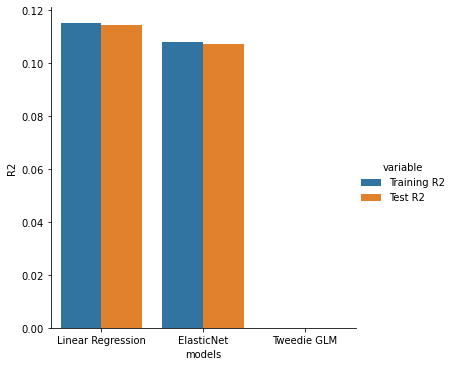

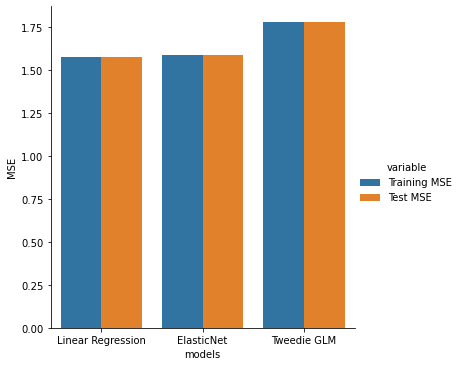

In [58]:
# Plot r2 and mse
models = ['Linear Regression', 'ElasticNet', 'Tweedie GLM']
training_r2 = [lr_tr_r2, en_tr_r2, glm_tr_r2]
test_r2 = [lr_r2, en_r2, glm_r2]
training_mse = [lr_tr_mse, en_tr_mse, glm_tr_mse]
test_mse = [lr_mse, en_mse, glm_mse]
plt_position = np.arange(len(models))

plt_r2 = pd.DataFrame(data={
    'models': models,
    'Training R2': training_r2,
    'Test R2': test_r2
})

plt_mse = pd.DataFrame(data={
    'models': models,
    'Training MSE': training_mse,
    'Test MSE': test_mse
})

plt_r2 = pd.melt(plt_r2, id_vars=['models'], value_name='R2')
sns.catplot(data=plt_r2, x='models', y='R2', hue='variable', kind='bar')

plt_mse = pd.melt(plt_mse, id_vars=['models'], value_name='MSE')
sns.catplot(data=plt_mse, x='models', y='MSE', hue='variable', kind='bar')